In [1]:
# code for loading the format for the notebook
import os
path = os.getcwd()
path

'/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/Experiment'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
DATA_PATH = '/home/dtd/Documents/interpretable_machine_learning/Source Code/data/rhc.csv'

In [4]:
# feel free to experiment with more
AGE = 'age'
MEANBP1 = 'meanbp1'
CAT1 = 'cat1'
SEX = 'sex'
DEATH = 'death' # outcome variable in the our raw data
SWANG1 = 'swang1' # treatment variable in our raw data
TREATMENT = 'treatment'

num_cols = [AGE, MEANBP1]
cat_cols = [CAT1, SEX, DEATH, SWANG1]

input_path = 'rhc.csv'
dtype = {col: 'category' for col in cat_cols}
df = pd.read_csv(DATA_PATH, usecols=num_cols + cat_cols, dtype=dtype)
print(df.shape)
df.head()

(5735, 6)


,cat1,death,age,sex,meanbp1,swang1
0,COPD,No,70.25098,Male,41.0,No RHC
1,MOSF w/Sepsis,Yes,78.17896,Female,63.0,RHC
2,MOSF w/Malignancy,No,46.09198,Female,57.0,RHC
3,ARF,Yes,75.33197,Female,55.0,No RHC
4,MOSF w/Sepsis,Yes,67.90997,Male,65.0,RHC


In [5]:
cat1_col_mapping = {
    'ARF': 'arf',
    'MOSF w/Sepsis': 'mosf_sepsis',
    'COPD': 'copd',
    'CHF': 'chf',
    'Coma': 'coma',
    'MOSF w/Malignancy': 'mosf',
    'Cirrhosis': 'cirrhosis',
    'Lung Cancer': 'lung_cancer',
    'Colon Cancer': 'colon_cancer'
}
df[CAT1] = df[CAT1].replace(cat1_col_mapping)

# convert features' value to numerical value, and store the
# numerical value to the original value mapping
col_mappings = {}
for col in (DEATH, SWANG1, SEX):
    col_mapping = dict(enumerate(df[col].cat.categories))
    col_mappings[col] = col_mapping
print(col_mappings)

for col in (DEATH, SWANG1, SEX):
    df[col] = df[col].cat.codes

df = df.rename({SWANG1: TREATMENT}, axis=1)
df.head()

{'death': {0: 'No', 1: 'Yes'}, 'swang1': {0: 'No RHC', 1: 'RHC'}, 'sex': {0: 'Female', 1: 'Male'}}


,cat1,death,age,sex,meanbp1,treatment
0,copd,0,70.25098,1,41.0,0
1,mosf_sepsis,1,78.17896,0,63.0,1
2,mosf,0,46.09198,0,57.0,1
3,arf,1,75.33197,0,55.0,0
4,mosf_sepsis,1,67.90997,1,65.0,1


In [6]:
cat_cols = [CAT1]
df_one_hot = pd.get_dummies(df[cat_cols], drop_first=True)
df_cleaned = pd.concat([df[num_cols], df_one_hot, df[[SEX, TREATMENT, DEATH]]], axis=1)
df_cleaned.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
0,70.25098,41.0,0,0,0,0,1,0,0,0,1,0,0
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
3,75.33197,55.0,0,0,0,0,0,0,0,0,0,0,1
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1


In [7]:
features = df_cleaned.columns.tolist()
features.remove(TREATMENT)
features.remove(DEATH)
agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = df_cleaned.groupby(TREATMENT).agg(agg_operations)
# merge MultiIndex columns together into 1 level
# table_one.columns = ['_'.join(col) for col in table_one.columns.values]
table_one.head()

treatment        age               meanbp1             cat1_chf  \
              count       mean        std       mean        std      mean   
treatment                                                                   
0              3551  61.760926  17.287674  84.868629  38.874134  0.069558   
1              2184  60.749836  15.630698  68.197802  34.242209  0.095696   

                    cat1_cirrhosis           cat1_colon_cancer  ... cat1_copd  \
                std           mean       std              mean  ...      mean   
treatment                                                       ...             
0          0.254436       0.049282  0.216486          0.001690  ...  0.112363   
1          0.294241       0.022436  0.148130          0.000458  ...  0.026557   

                    cat1_lung_cancer           cat1_mosf            \
                std             mean       std      mean       std   
treatment                                                            
0          0.315857         0.009575  0.097395  0.067868  0.251555   
1          0.160821         0.002289  0.047804  0.072344  0.259117   

          cat1_mosf_sepsis                 sex            
                      mean       std      mean       std  
treatment                                                 
0                 0.148409  0.355555  0.539003  0.498547  
1                 0.320513  0.466781  0.585165  0.492806  

[2 rows x 23 columns]

In [8]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.0614
1,meanbp1,0.4551
2,cat1_chf,0.0950
3,cat1_cirrhosis,0.1447
4,cat1_colon_cancer,0.0376
5,cat1_coma,0.2073
6,cat1_copd,0.3424
7,cat1_lung_cancer,0.0950
8,cat1_mosf,0.0175
9,cat1_mosf_sepsis,0.4148


In [9]:
death = df_cleaned[DEATH]
treatment = df_cleaned[TREATMENT]
df_cleaned = df_cleaned.drop([DEATH, TREATMENT], axis=1)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape

(5735, 11)

## Calculate propensity score 

In [10]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.20154118, 0.550909  , 0.40984625, ..., 0.17665094, 0.18749943,
       0.22041186])

In [12]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (2184,)
control count: (3551,)


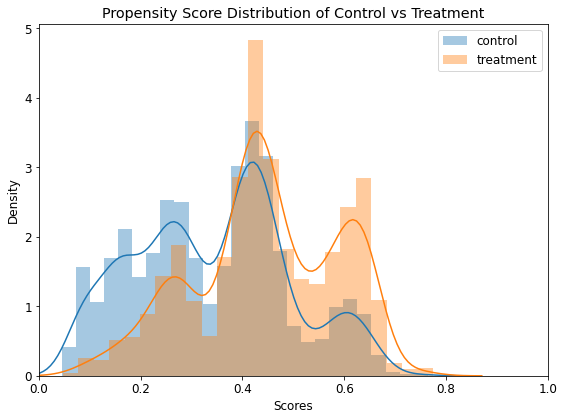

In [13]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors
    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[1703],
       [1329],
       [2782],
       ...,
       [1728],
       [1909],
       [2546]])

In [15]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([  0, 810, 309, 121,  47,  12,   6,   7,   3,   4])

In [23]:
df_cleaned[TREATMENT] = treatment
df_cleaned[DEATH] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1
9,48.42398,73.0,0,0,0,0,0,0,0,0,0,1,0
11,68.34796,50.0,0,0,0,0,0,0,0,0,1,1,0


In [17]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=3)
sim_indices

array([[1703, 3447, 1518],
       [1329, 1146, 3142],
       [2782,  951, 1640],
       ...,
       [1728, 2567, 2667],
       [1909, 2259, 2099],
       [2546, 2579, 2675]])

In [26]:
sim_indices[:,0]

array([1703, 1329, 2782, ..., 1728, 1909, 2546])

In [27]:
df_cleaned[TREATMENT] = treatment
df_cleaned[DEATH] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1
9,48.42398,73.0,0,0,0,0,0,0,0,0,0,1,0
11,68.34796,50.0,0,0,0,0,0,0,0,0,1,1,0


In [20]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,age,0.0160
1,meanbp1,0.0072
2,cat1_chf,0.0184
3,cat1_cirrhosis,0.0091
4,cat1_colon_cancer,0.0707
5,cat1_coma,0.0091
6,cat1_copd,0.0557
7,cat1_lung_cancer,0.0626
8,cat1_mosf,0.0035
9,cat1_mosf_sepsis,0.0039


In [21]:
num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[DEATH].values, df_neg[DEATH].values)

number of matched pairs:  2184


Ttest_relResult(statistic=2.98993204105555, pvalue=0.0028215776367738962)

## References
http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html